In [1]:
import joblib
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [14]:
# load the model
model = joblib.load('model/best_LGB_10k_Undersampled_BestParams.pkl')

#load the X_train dataframe
df = pd.read_pickle('../data/cleaned/client_data_api_dashboard.pkl')

# load full data
full_data = pd.read_csv('../data/raw/application_train.csv')

# annuity (loan interest)
df_AMT_ANNUITY = pd.read_pickle('../data/cleaned/df_amt_annuity.pkl')

In [15]:
df = df.join(df_AMT_ANNUITY)

In [16]:
df.AMT_ANNUITY.isna().sum()

0

In [19]:
def get_Xy_full(df):
    X = df.drop(columns=['TARGET','AMT_ANNUITY'])
    y = df.TARGET
    return X, y

In [20]:
X, y = get_Xy_full(df)

# 1

In [21]:
N_SAMPLES = df.shape[0]
N_THRESHOLDS = 40
CLASS_1_RATIO = df[df.TARGET==1].shape[0] / df[df.TARGET==0].shape[0]

# ndarray
y_true = df.TARGET.values

# ndarray
y_pred = model.predict_proba(X)[:,1]

THRESHOLDS = [ i/float(N_THRESHOLDS) for i in range(N_THRESHOLDS+1) ]

# 2

In [22]:
def cm(y_true, y_pred, threshold=0.5):
    return confusion_matrix(
        y_true,
        y_pred>=threshold
    )
def confusion_curve(y_true, y_pred):
    return [
        cm(y_true, y_pred, thr).flatten()
        for thr in THRESHOLDS
    ]

print("Confusion matrix at 50%:\n", cm(y_true, y_pred))

Confusion matrix at 50%:
 [[196704  85982]
 [  7511  17314]]


# 3

In [28]:
CURVES = pd.DataFrame(
    confusion_curve(y_true, y_pred),
    columns = [ 'TN', 'FP', 'FN', 'TP', ]
) / N_SAMPLES  # Normalized per sample

CURVES['threshold'] = THRESHOLDS

In [30]:
CURVES.to_pickle('../data/cleaned/curves.pkl')

# 4

In [25]:
# EXAMPLE LOAN DETAILS
amount_loan = df.head(1)['AMT_CREDIT'].values[0]
amount_interest = df.head(1)['AMT_ANNUITY'].values[0]

print ('Loan Value:',amount_loan)
print ('Interest  :',amount_interest)


Loan Value: 406597.5
Interest  : 24700.5


In [26]:
# W0 = volume of interests that are paid back
# W1 = estimation of the averaged capital lost for bad customers
# if W1/W0 penalty is lower than (1/class1ratio - 1) then gains are always positive
#    (8% => W1/W0 = 11.5)
# but it doesn't mean maximal gain at any threshold!!
# W0 =  27108.0  # average loan value
# W1 = 599025.0  # avergae annuity value
################
W0 =  1000.0  # penalty=12.5
W1 = 12000.0  #
################
W0 = amount_interest
W1 = amount_loan

CURVES['EARNED']     = W0*CURVES.TN
CURVES['NOT_EARNED'] = W0*CURVES.FP
CURVES['LOST']       = W1*CURVES.FN
CURVES['GAIN']       = CURVES.EARNED - CURVES.LOST
CURVES['MAX_GAIN']   = CURVES.EARNED + CURVES.NOT_EARNED

# 5

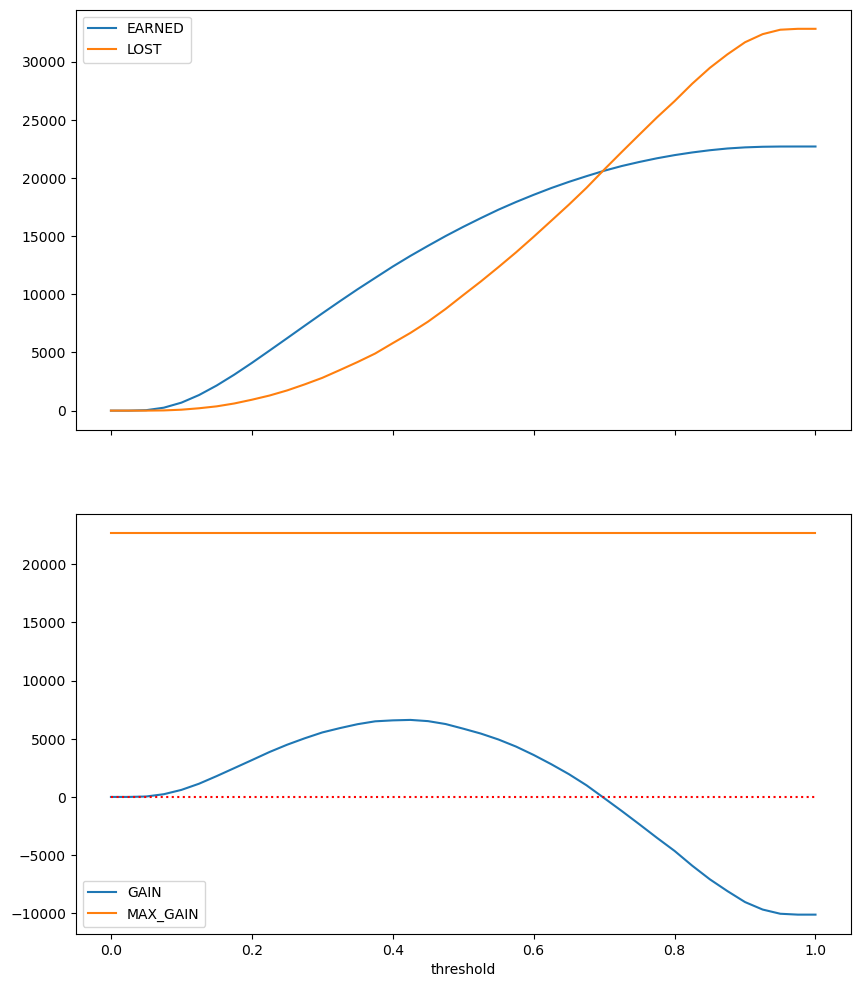

In [27]:
fig, ax = plt.subplots(2, sharex=True, figsize =(10, 12))

CURVES.plot(ax=ax[0], x='threshold', y=['EARNED', 'LOST'])
CURVES.plot(ax=ax[1], x='threshold', y=['GAIN', 'MAX_GAIN'])
ax[1].plot([0,1],[0,0], 'r:')

# 99